In [1]:
import torch

from datetime import datetime
from torch.utils.tensorboard.writer import SummaryWriter
from reference_models.heidenreich.vae import VAE
from tqdm import tqdm
from torchvision import datasets
from torchvision.transforms import v2


batch_size = 128
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Lambda(lambda x: x.view(-1) - 0.5),
    ]
)

# Download and load the training data
train_data = datasets.MNIST(
    "~/.pytorch/MNIST_data/",
    download=True,
    train=True,
    transform=transform,
)
# Download and load the test data
test_data = datasets.MNIST(
    "~/.pytorch/MNIST_data/",
    download=True,
    train=False,
    transform=transform,
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True
)

ModuleNotFoundError: No module named 'torch'

In [2]:
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
hidden_dim = 512

device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
model = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=weight_decay)
writer = SummaryWriter(f'runs/mnist/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

In [3]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.

    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode

    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx

        data = data.to(device)

        # optimizer.zero_grad()  # Zero the gradients
        for param in model.parameters():
            param.grad = None

        output = model(data)  # Forward pass
        loss = output.loss

        loss.backward()

        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1.0 / 2)

            print(
                f"Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}"
            )

            if writer is not None:
                global_step = n_upd
                writer.add_scalar("Loss/Train", loss.item(), global_step)
                writer.add_scalar(
                    "Loss/Train/BCE", output.loss_recon.item(), global_step
                )
                writer.add_scalar("Loss/Train/KLD", output.loss_kl.item(), global_step)
                writer.add_scalar("GradNorm/Train", total_norm, global_step)

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()  # Update the model parameters

    return prev_updates + len(dataloader)


def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.

    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0

    with torch.no_grad():
        for data, target in tqdm(dataloader, desc="Testing"):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data

            output = model(data, compute_loss=True)  # Forward pass

            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(
        f"====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})"
    )

    if writer is not None:
        writer.add_scalar("Loss/Test", test_loss, global_step=cur_step)
        writer.add_scalar(
            "Loss/Test/BCE", output.loss_recon.item(), global_step=cur_step
        )
        writer.add_scalar("Loss/Test/KLD", output.loss_kl.item(), global_step=cur_step)

        # Log reconstructions
        writer.add_images(
            "Test/Reconstructions",
            output.x_recon.view(-1, 1, 28, 28),
            global_step=cur_step,
        )
        writer.add_images(
            "Test/Originals", data.view(-1, 1, 28, 28), global_step=cur_step
        )

        # Log random samples from the latent space
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decode(z)
        writer.add_images(
            "Test/Samples", samples.view(-1, 1, 28, 28), global_step=cur_step
        )

In [4]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/50


  2%|▏         | 11/469 [00:00<00:22, 20.53it/s]

Step 0 (N samples: 0), Loss: 543.4069 (Recon: 543.2268, KL: 0.1800) Grad: 13.1147


 25%|██▌       | 118/469 [00:01<00:04, 83.06it/s]

Step 100 (N samples: 12,800), Loss: 184.5940 (Recon: 182.6955, KL: 1.8985) Grad: 30.1721


 46%|████▋     | 218/469 [00:03<00:02, 85.20it/s]

Step 200 (N samples: 25,600), Loss: 191.5056 (Recon: 189.4630, KL: 2.0426) Grad: 38.7934


 66%|██████▌   | 310/469 [00:04<00:01, 84.90it/s]

Step 300 (N samples: 38,400), Loss: 190.3998 (Recon: 188.1912, KL: 2.2086) Grad: 34.1212


 88%|████████▊ | 411/469 [00:05<00:00, 85.43it/s]

Step 400 (N samples: 51,200), Loss: 173.8468 (Recon: 169.6350, KL: 4.2118) Grad: 46.2487


Testing: 100%|██████████| 79/79 [00:00<00:00, 85.19it/s]


====> Test set loss: 169.1270 (BCE: 164.6811, KLD: 4.4459)
Epoch 2/50


  9%|▉         | 44/469 [00:00<00:05, 71.25it/s]

Step 500 (N samples: 64,000), Loss: 167.5432 (Recon: 162.9339, KL: 4.6093) Grad: 46.3613


 31%|███       | 144/469 [00:01<00:03, 85.00it/s]

Step 600 (N samples: 76,800), Loss: 160.6299 (Recon: 156.0677, KL: 4.5622) Grad: 66.5793


 52%|█████▏    | 243/469 [00:03<00:02, 83.99it/s]

Step 700 (N samples: 89,600), Loss: 159.4976 (Recon: 154.4976, KL: 5.0000) Grad: 67.5388


 73%|███████▎  | 343/469 [00:04<00:01, 85.01it/s]

Step 800 (N samples: 102,400), Loss: 156.1631 (Recon: 151.1102, KL: 5.0528) Grad: 78.3883


 94%|█████████▍| 443/469 [00:05<00:00, 83.20it/s]

Step 900 (N samples: 115,200), Loss: 153.6590 (Recon: 148.1729, KL: 5.4861) Grad: 60.3418


Testing: 100%|██████████| 79/79 [00:00<00:00, 88.04it/s]


====> Test set loss: 156.2551 (BCE: 151.0250, KLD: 5.2301)
Epoch 3/50


 17%|█▋        | 80/469 [00:01<00:04, 82.12it/s]

Step 1,000 (N samples: 128,000), Loss: 155.1180 (Recon: 149.9364, KL: 5.1815) Grad: 35.8153


 38%|███▊      | 179/469 [00:02<00:03, 82.77it/s]

Step 1,100 (N samples: 140,800), Loss: 157.9228 (Recon: 152.3461, KL: 5.5767) Grad: 73.6300


 59%|█████▉    | 279/469 [00:03<00:02, 82.61it/s]

Step 1,200 (N samples: 153,600), Loss: 147.1937 (Recon: 141.6124, KL: 5.5813) Grad: 41.0391


 81%|████████  | 378/469 [00:04<00:01, 82.94it/s]

Step 1,300 (N samples: 166,400), Loss: 158.8624 (Recon: 153.2203, KL: 5.6421) Grad: 63.4077


100%|██████████| 469/469 [00:05<00:00, 79.23it/s]


Step 1,400 (N samples: 179,200), Loss: 157.4349 (Recon: 151.7659, KL: 5.6690) Grad: 65.0126


Testing: 100%|██████████| 79/79 [00:00<00:00, 86.18it/s] 


====> Test set loss: 153.0694 (BCE: 147.4224, KLD: 5.6470)
Epoch 4/50


 23%|██▎       | 110/469 [00:01<00:04, 84.15it/s]

Step 1,500 (N samples: 192,000), Loss: 149.1451 (Recon: 143.1976, KL: 5.9475) Grad: 46.7504


 45%|████▍     | 210/469 [00:02<00:03, 84.62it/s]

Step 1,600 (N samples: 204,800), Loss: 154.2340 (Recon: 148.1493, KL: 6.0847) Grad: 98.3724


 66%|██████▌   | 309/469 [00:03<00:01, 82.93it/s]

Step 1,700 (N samples: 217,600), Loss: 158.8797 (Recon: 153.3383, KL: 5.5414) Grad: 141.2032


 87%|████████▋ | 408/469 [00:05<00:00, 81.45it/s]

Step 1,800 (N samples: 230,400), Loss: 147.5333 (Recon: 141.6530, KL: 5.8803) Grad: 136.0254


Testing: 100%|██████████| 79/79 [00:00<00:00, 88.20it/s] 


====> Test set loss: 149.5501 (BCE: 143.6666, KLD: 5.8835)
Epoch 5/50


  8%|▊         | 37/469 [00:00<00:06, 68.38it/s]

Step 1,900 (N samples: 243,200), Loss: 143.5567 (Recon: 137.5051, KL: 6.0516) Grad: 80.5070


 29%|██▉       | 136/469 [00:01<00:04, 81.48it/s]

Step 2,000 (N samples: 256,000), Loss: 146.4012 (Recon: 140.4876, KL: 5.9135) Grad: 61.8046


 50%|█████     | 235/469 [00:03<00:02, 85.26it/s]

Step 2,100 (N samples: 268,800), Loss: 153.7611 (Recon: 147.6425, KL: 6.1187) Grad: 106.6330


 71%|███████   | 334/469 [00:04<00:01, 83.24it/s]

Step 2,200 (N samples: 281,600), Loss: 151.5617 (Recon: 145.6523, KL: 5.9094) Grad: 70.9798


 94%|█████████▍| 442/469 [00:05<00:00, 83.98it/s]

Step 2,300 (N samples: 294,400), Loss: 148.9093 (Recon: 142.9750, KL: 5.9343) Grad: 63.1320


Testing: 100%|██████████| 79/79 [00:00<00:00, 87.21it/s] 


====> Test set loss: 146.7018 (BCE: 140.5070, KLD: 6.1948)
Epoch 6/50


 14%|█▎        | 64/469 [00:01<00:05, 78.28it/s]

Step 2,400 (N samples: 307,200), Loss: 140.3012 (Recon: 134.0778, KL: 6.2233) Grad: 120.1158


 37%|███▋      | 172/469 [00:02<00:03, 84.98it/s]

Step 2,500 (N samples: 320,000), Loss: 144.4487 (Recon: 138.3745, KL: 6.0741) Grad: 87.9034


 58%|█████▊    | 272/469 [00:03<00:02, 84.08it/s]

Step 2,600 (N samples: 332,800), Loss: 147.4062 (Recon: 141.4228, KL: 5.9835) Grad: 82.6368


 78%|███████▊  | 364/469 [00:04<00:01, 84.28it/s]

Step 2,700 (N samples: 345,600), Loss: 154.0478 (Recon: 147.8026, KL: 6.2452) Grad: 106.4584


 99%|█████████▉| 464/469 [00:05<00:00, 85.76it/s]

Step 2,800 (N samples: 358,400), Loss: 151.3350 (Recon: 145.1947, KL: 6.1403) Grad: 88.0487


Testing: 100%|██████████| 79/79 [00:00<00:00, 87.33it/s] 


====> Test set loss: 146.7871 (BCE: 140.6464, KLD: 6.1407)
Epoch 7/50


 21%|██▏       | 100/469 [00:01<00:04, 83.89it/s]

Step 2,900 (N samples: 371,200), Loss: 149.5516 (Recon: 143.0596, KL: 6.4920) Grad: 122.5320


 43%|████▎     | 200/469 [00:02<00:03, 83.02it/s]

Step 3,000 (N samples: 384,000), Loss: 150.0950 (Recon: 143.7850, KL: 6.3101) Grad: 79.4561


 64%|██████▍   | 299/469 [00:03<00:02, 84.25it/s]

Step 3,100 (N samples: 396,800), Loss: 152.4213 (Recon: 146.2495, KL: 6.1719) Grad: 157.1232


 85%|████████▍ | 398/469 [00:05<00:00, 82.80it/s]

Step 3,200 (N samples: 409,600), Loss: 147.1416 (Recon: 140.7756, KL: 6.3660) Grad: 135.5168


Testing: 100%|██████████| 79/79 [00:00<00:00, 88.53it/s] 


====> Test set loss: 144.7662 (BCE: 138.3862, KLD: 6.3800)
Epoch 8/50


  6%|▌         | 28/469 [00:00<00:07, 60.78it/s]

Step 3,300 (N samples: 422,400), Loss: 146.4927 (Recon: 140.3921, KL: 6.1006) Grad: 156.6233


 27%|██▋       | 127/469 [00:01<00:04, 84.43it/s]

Step 3,400 (N samples: 435,200), Loss: 144.9676 (Recon: 138.5408, KL: 6.4267) Grad: 96.3073


 48%|████▊     | 227/469 [00:02<00:02, 84.64it/s]

Step 3,500 (N samples: 448,000), Loss: 144.5239 (Recon: 138.1184, KL: 6.4055) Grad: 73.3984


 70%|██████▉   | 328/469 [00:04<00:01, 84.82it/s]

Step 3,600 (N samples: 460,800), Loss: 147.8870 (Recon: 141.4781, KL: 6.4089) Grad: 134.0780


 91%|█████████▏| 429/469 [00:05<00:00, 86.64it/s]

Step 3,700 (N samples: 473,600), Loss: 142.1823 (Recon: 135.8528, KL: 6.3295) Grad: 108.9374


Testing: 100%|██████████| 79/79 [00:00<00:00, 88.10it/s] 


====> Test set loss: 143.3485 (BCE: 136.9095, KLD: 6.4390)
Epoch 9/50


 13%|█▎        | 60/469 [00:00<00:05, 75.98it/s]

Step 3,800 (N samples: 486,400), Loss: 149.6623 (Recon: 143.3407, KL: 6.3216) Grad: 127.5034


 34%|███▍      | 159/469 [00:02<00:03, 82.78it/s]

Step 3,900 (N samples: 499,200), Loss: 149.3812 (Recon: 143.0785, KL: 6.3027) Grad: 150.9309


 55%|█████▌    | 260/469 [00:03<00:02, 84.84it/s]

Step 4,000 (N samples: 512,000), Loss: 145.5063 (Recon: 139.1225, KL: 6.3838) Grad: 101.2286


 77%|███████▋  | 359/469 [00:04<00:01, 83.93it/s]

Step 4,100 (N samples: 524,800), Loss: 140.2528 (Recon: 133.9306, KL: 6.3222) Grad: 86.0445


 98%|█████████▊| 459/469 [00:05<00:00, 87.06it/s]

Step 4,200 (N samples: 537,600), Loss: 137.9826 (Recon: 131.3868, KL: 6.5958) Grad: 72.4698


Testing: 100%|██████████| 79/79 [00:00<00:00, 88.38it/s] 


====> Test set loss: 147.8345 (BCE: 141.6503, KLD: 6.1842)
Epoch 10/50


 19%|█▉        | 90/469 [00:01<00:04, 80.05it/s]

Step 4,300 (N samples: 550,400), Loss: 151.1061 (Recon: 144.7901, KL: 6.3160) Grad: 213.6649


 40%|████      | 189/469 [00:02<00:03, 81.77it/s]

Step 4,400 (N samples: 563,200), Loss: 143.0909 (Recon: 136.4432, KL: 6.6477) Grad: 123.3828


 62%|██████▏   | 289/469 [00:03<00:02, 84.51it/s]

Step 4,500 (N samples: 576,000), Loss: 140.0806 (Recon: 133.4855, KL: 6.5951) Grad: 108.3484


 83%|████████▎ | 388/469 [00:04<00:00, 83.20it/s]

Step 4,600 (N samples: 588,800), Loss: 139.0300 (Recon: 132.5026, KL: 6.5274) Grad: 108.7981


Testing: 100%|██████████| 79/79 [00:00<00:00, 88.81it/s] 


====> Test set loss: 143.6385 (BCE: 137.4102, KLD: 6.2283)
Epoch 11/50


  6%|▌         | 26/469 [00:00<00:07, 58.78it/s]

Step 4,700 (N samples: 601,600), Loss: 141.1157 (Recon: 134.9438, KL: 6.1719) Grad: 169.2237


 27%|██▋       | 127/469 [00:01<00:04, 82.32it/s]

Step 4,800 (N samples: 614,400), Loss: 145.3117 (Recon: 138.9830, KL: 6.3286) Grad: 82.7374


 48%|████▊     | 226/469 [00:02<00:02, 83.77it/s]

Step 4,900 (N samples: 627,200), Loss: 141.6945 (Recon: 135.0086, KL: 6.6859) Grad: 104.5863


 70%|██████▉   | 326/469 [00:04<00:01, 84.68it/s]

Step 5,000 (N samples: 640,000), Loss: 152.6497 (Recon: 146.0999, KL: 6.5498) Grad: 112.5636


 91%|█████████ | 427/469 [00:05<00:00, 83.36it/s]

Step 5,100 (N samples: 652,800), Loss: 150.4181 (Recon: 144.0349, KL: 6.3833) Grad: 125.6869


Testing: 100%|██████████| 79/79 [00:00<00:00, 86.57it/s] 


====> Test set loss: 142.6042 (BCE: 136.1096, KLD: 6.4946)
Epoch 12/50


 11%|█▏        | 53/469 [00:00<00:05, 75.80it/s]

Step 5,200 (N samples: 665,600), Loss: 143.4317 (Recon: 137.0594, KL: 6.3723) Grad: 125.4975


 32%|███▏      | 152/469 [00:02<00:03, 83.03it/s]

Step 5,300 (N samples: 678,400), Loss: 143.2063 (Recon: 136.7729, KL: 6.4334) Grad: 110.6033


 54%|█████▎    | 251/469 [00:03<00:02, 83.07it/s]

Step 5,400 (N samples: 691,200), Loss: 135.4088 (Recon: 128.8870, KL: 6.5218) Grad: 87.0959


 75%|███████▍  | 350/469 [00:04<00:01, 81.98it/s]

Step 5,500 (N samples: 704,000), Loss: 145.1239 (Recon: 138.5825, KL: 6.5414) Grad: 143.6173


 96%|█████████▋| 452/469 [00:05<00:00, 85.78it/s]

Step 5,600 (N samples: 716,800), Loss: 143.7596 (Recon: 137.2122, KL: 6.5474) Grad: 93.9337


Testing: 100%|██████████| 79/79 [00:00<00:00, 87.30it/s] 


====> Test set loss: 141.1224 (BCE: 134.5440, KLD: 6.5785)
Epoch 13/50


 19%|█▉        | 89/469 [00:01<00:04, 81.83it/s]

Step 5,700 (N samples: 729,600), Loss: 134.7781 (Recon: 128.0034, KL: 6.7747) Grad: 154.7853


 40%|████      | 189/469 [00:02<00:03, 84.11it/s]

Step 5,800 (N samples: 742,400), Loss: 144.5723 (Recon: 138.0868, KL: 6.4854) Grad: 115.6377


 62%|██████▏   | 289/469 [00:03<00:02, 83.02it/s]

Step 5,900 (N samples: 755,200), Loss: 135.5911 (Recon: 129.0582, KL: 6.5329) Grad: 100.6922


 83%|████████▎ | 388/469 [00:04<00:00, 85.07it/s]

Step 6,000 (N samples: 768,000), Loss: 141.0708 (Recon: 134.5077, KL: 6.5631) Grad: 130.1537


Testing: 100%|██████████| 79/79 [00:00<00:00, 87.14it/s] 


====> Test set loss: 141.7909 (BCE: 135.1234, KLD: 6.6676)
Epoch 14/50


  4%|▍         | 18/469 [00:00<00:09, 47.74it/s]

Step 6,100 (N samples: 780,800), Loss: 146.1747 (Recon: 139.5089, KL: 6.6659) Grad: 113.3772


 25%|██▌       | 118/469 [00:01<00:04, 85.63it/s]

Step 6,200 (N samples: 793,600), Loss: 137.8167 (Recon: 131.0227, KL: 6.7941) Grad: 104.6300


 46%|████▋     | 218/469 [00:02<00:02, 84.52it/s]

Step 6,300 (N samples: 806,400), Loss: 143.1730 (Recon: 136.6045, KL: 6.5685) Grad: 118.9225


 68%|██████▊   | 318/469 [00:04<00:01, 85.02it/s]

Step 6,400 (N samples: 819,200), Loss: 145.0666 (Recon: 138.7274, KL: 6.3392) Grad: 177.2799


 89%|████████▉ | 417/469 [00:05<00:00, 83.27it/s]

Step 6,500 (N samples: 832,000), Loss: 137.8315 (Recon: 131.4464, KL: 6.3851) Grad: 61.4457


Testing: 100%|██████████| 79/79 [00:00<00:00, 86.96it/s]


====> Test set loss: 144.9239 (BCE: 138.3861, KLD: 6.5377)
Epoch 15/50


 10%|▉         | 46/469 [00:00<00:05, 72.17it/s]

Step 6,600 (N samples: 844,800), Loss: 145.2583 (Recon: 138.5788, KL: 6.6794) Grad: 138.1847


 31%|███       | 146/469 [00:02<00:03, 81.69it/s]

Step 6,700 (N samples: 857,600), Loss: 152.6723 (Recon: 146.0655, KL: 6.6068) Grad: 139.5654


 52%|█████▏    | 246/469 [00:03<00:02, 83.71it/s]

Step 6,800 (N samples: 870,400), Loss: 133.6553 (Recon: 127.0655, KL: 6.5898) Grad: 105.6291


 74%|███████▍  | 346/469 [00:04<00:01, 84.54it/s]

Step 6,900 (N samples: 883,200), Loss: 144.3659 (Recon: 137.9012, KL: 6.4647) Grad: 87.4374


 95%|█████████▌| 447/469 [00:05<00:00, 84.34it/s]

Step 7,000 (N samples: 896,000), Loss: 141.0738 (Recon: 134.5631, KL: 6.5107) Grad: 96.7907


Testing: 100%|██████████| 79/79 [00:00<00:00, 87.01it/s] 


====> Test set loss: 140.6102 (BCE: 134.0099, KLD: 6.6003)
Epoch 16/50


 17%|█▋        | 81/469 [00:01<00:04, 81.06it/s]

Step 7,100 (N samples: 908,800), Loss: 141.1794 (Recon: 134.6112, KL: 6.5682) Grad: 165.8632


 39%|███▉      | 182/469 [00:02<00:03, 83.54it/s]

Step 7,200 (N samples: 921,600), Loss: 145.1523 (Recon: 138.6585, KL: 6.4938) Grad: 128.7607


 58%|█████▊    | 274/469 [00:03<00:02, 83.89it/s]

Step 7,300 (N samples: 934,400), Loss: 146.0763 (Recon: 139.4165, KL: 6.6598) Grad: 122.7807


 80%|███████▉  | 373/469 [00:04<00:01, 78.95it/s]

Step 7,400 (N samples: 947,200), Loss: 131.2472 (Recon: 124.5281, KL: 6.7191) Grad: 121.0011


100%|██████████| 469/469 [00:05<00:00, 79.32it/s]


Step 7,500 (N samples: 960,000), Loss: 142.9752 (Recon: 136.5209, KL: 6.4544) Grad: 128.8344


Testing: 100%|██████████| 79/79 [00:00<00:00, 87.81it/s] 


====> Test set loss: 141.5160 (BCE: 135.0087, KLD: 6.5073)
Epoch 17/50


 23%|██▎       | 109/469 [00:01<00:04, 85.00it/s]

Step 7,600 (N samples: 972,800), Loss: 140.6741 (Recon: 134.0268, KL: 6.6473) Grad: 148.6300


 44%|████▍     | 208/469 [00:02<00:03, 82.31it/s]

Step 7,700 (N samples: 985,600), Loss: 132.7065 (Recon: 125.9825, KL: 6.7240) Grad: 97.3035


 65%|██████▌   | 307/469 [00:03<00:02, 79.65it/s]

Step 7,800 (N samples: 998,400), Loss: 144.3309 (Recon: 137.6584, KL: 6.6725) Grad: 181.9309


 87%|████████▋ | 406/469 [00:05<00:00, 82.95it/s]

Step 7,900 (N samples: 1,011,200), Loss: 136.7975 (Recon: 130.0718, KL: 6.7256) Grad: 127.3942


Testing: 100%|██████████| 79/79 [00:00<00:00, 88.11it/s] 


====> Test set loss: 140.1017 (BCE: 133.4487, KLD: 6.6530)
Epoch 18/50


  9%|▉         | 43/469 [00:00<00:06, 69.65it/s]

Step 8,000 (N samples: 1,024,000), Loss: 138.9669 (Recon: 132.1873, KL: 6.7796) Grad: 114.7496


 30%|███       | 143/469 [00:02<00:04, 81.11it/s]

Step 8,100 (N samples: 1,036,800), Loss: 138.2190 (Recon: 131.3691, KL: 6.8499) Grad: 129.0804


 52%|█████▏    | 244/469 [00:03<00:02, 84.90it/s]

Step 8,200 (N samples: 1,049,600), Loss: 145.3165 (Recon: 138.6243, KL: 6.6922) Grad: 80.1304


 73%|███████▎  | 343/469 [00:04<00:01, 83.72it/s]

Step 8,300 (N samples: 1,062,400), Loss: 136.9506 (Recon: 130.3434, KL: 6.6073) Grad: 85.3701


 94%|█████████▍| 442/469 [00:05<00:00, 82.19it/s]

Step 8,400 (N samples: 1,075,200), Loss: 136.7472 (Recon: 129.9667, KL: 6.7805) Grad: 115.9406


Testing: 100%|██████████| 79/79 [00:00<00:00, 86.89it/s] 


====> Test set loss: 139.2830 (BCE: 132.6825, KLD: 6.6005)
Epoch 19/50


 15%|█▌        | 72/469 [00:01<00:04, 81.79it/s]

Step 8,500 (N samples: 1,088,000), Loss: 141.2941 (Recon: 134.3837, KL: 6.9103) Grad: 153.3500


 36%|███▋      | 171/469 [00:02<00:03, 83.78it/s]

Step 8,600 (N samples: 1,100,800), Loss: 135.3766 (Recon: 128.6686, KL: 6.7080) Grad: 113.5749


 58%|█████▊    | 271/469 [00:03<00:02, 84.69it/s]

Step 8,700 (N samples: 1,113,600), Loss: 139.1717 (Recon: 132.4276, KL: 6.7441) Grad: 137.0431


 79%|███████▉  | 370/469 [00:04<00:01, 82.23it/s]

Step 8,800 (N samples: 1,126,400), Loss: 141.4918 (Recon: 134.6757, KL: 6.8161) Grad: 123.6657


100%|██████████| 469/469 [00:05<00:00, 79.87it/s]


Step 8,900 (N samples: 1,139,200), Loss: 137.1869 (Recon: 130.3418, KL: 6.8451) Grad: 68.6180


Testing: 100%|██████████| 79/79 [00:00<00:00, 87.85it/s] 


====> Test set loss: 139.8027 (BCE: 133.1168, KLD: 6.6859)
Epoch 20/50


 21%|██▏       | 100/469 [00:01<00:04, 83.71it/s]

Step 9,000 (N samples: 1,152,000), Loss: 141.1876 (Recon: 134.4034, KL: 6.7843) Grad: 154.8895


 43%|████▎     | 200/469 [00:02<00:03, 82.96it/s]

Step 9,100 (N samples: 1,164,800), Loss: 144.8931 (Recon: 137.8918, KL: 7.0012) Grad: 148.3992


 64%|██████▍   | 299/469 [00:03<00:02, 82.32it/s]

Step 9,200 (N samples: 1,177,600), Loss: 138.4992 (Recon: 131.5928, KL: 6.9065) Grad: 88.3792


 85%|████████▍ | 398/469 [00:05<00:00, 83.73it/s]

Step 9,300 (N samples: 1,190,400), Loss: 138.4227 (Recon: 131.6696, KL: 6.7531) Grad: 168.6366


Testing: 100%|██████████| 79/79 [00:00<00:00, 87.59it/s] 


====> Test set loss: 139.6560 (BCE: 132.9520, KLD: 6.7040)
Epoch 21/50


  8%|▊         | 36/469 [00:00<00:06, 67.60it/s]

Step 9,400 (N samples: 1,203,200), Loss: 141.4583 (Recon: 134.6292, KL: 6.8291) Grad: 94.6531


 28%|██▊       | 133/469 [00:01<00:04, 82.67it/s]

Step 9,500 (N samples: 1,216,000), Loss: 141.6961 (Recon: 134.9603, KL: 6.7358) Grad: 115.9439


 50%|████▉     | 233/469 [00:03<00:02, 83.84it/s]

Step 9,600 (N samples: 1,228,800), Loss: 137.8092 (Recon: 131.0170, KL: 6.7922) Grad: 91.1950


 71%|███████   | 334/469 [00:04<00:01, 85.27it/s]

Step 9,700 (N samples: 1,241,600), Loss: 143.5220 (Recon: 136.7833, KL: 6.7387) Grad: 117.3087


 93%|█████████▎| 434/469 [00:05<00:00, 81.84it/s]

Step 9,800 (N samples: 1,254,400), Loss: 133.7131 (Recon: 126.9188, KL: 6.7943) Grad: 98.5674


Testing: 100%|██████████| 79/79 [00:00<00:00, 84.26it/s] 


====> Test set loss: 139.5530 (BCE: 132.6754, KLD: 6.8775)
Epoch 22/50


 13%|█▎        | 62/469 [00:01<00:05, 76.83it/s]

Step 9,900 (N samples: 1,267,200), Loss: 139.8250 (Recon: 133.2312, KL: 6.5938) Grad: 120.6144


 34%|███▍      | 161/469 [00:02<00:03, 81.86it/s]

Step 10,000 (N samples: 1,280,000), Loss: 141.5084 (Recon: 134.7716, KL: 6.7368) Grad: 115.3425


 56%|█████▌    | 262/469 [00:03<00:02, 82.99it/s]

Step 10,100 (N samples: 1,292,800), Loss: 138.3439 (Recon: 131.4513, KL: 6.8927) Grad: 129.5288


 77%|███████▋  | 361/469 [00:04<00:01, 82.10it/s]

Step 10,200 (N samples: 1,305,600), Loss: 146.6216 (Recon: 139.8929, KL: 6.7287) Grad: 133.9134


 99%|█████████▉| 466/469 [00:06<00:00, 67.57it/s]

Step 10,300 (N samples: 1,318,400), Loss: 139.4920 (Recon: 132.7872, KL: 6.7048) Grad: 202.1461


Testing: 100%|██████████| 79/79 [00:00<00:00, 85.79it/s] 


====> Test set loss: 140.2963 (BCE: 133.5743, KLD: 6.7220)
Epoch 23/50


 20%|█▉        | 92/469 [00:01<00:05, 64.82it/s]

Step 10,400 (N samples: 1,331,200), Loss: 143.6772 (Recon: 136.8575, KL: 6.8198) Grad: 103.2508


 41%|████▏     | 194/469 [00:02<00:03, 82.06it/s]

Step 10,500 (N samples: 1,344,000), Loss: 147.7154 (Recon: 140.7861, KL: 6.9293) Grad: 249.8100


 63%|██████▎   | 294/469 [00:03<00:02, 85.29it/s]

Step 10,600 (N samples: 1,356,800), Loss: 136.9764 (Recon: 130.2009, KL: 6.7755) Grad: 161.1492


 84%|████████▍ | 393/469 [00:05<00:00, 82.13it/s]

Step 10,700 (N samples: 1,369,600), Loss: 138.9262 (Recon: 131.9299, KL: 6.9963) Grad: 92.7993


Testing: 100%|██████████| 79/79 [00:00<00:00, 85.45it/s] 


====> Test set loss: 141.0411 (BCE: 134.3115, KLD: 6.7296)
Epoch 24/50


  6%|▌         | 26/469 [00:00<00:07, 58.07it/s]

Step 10,800 (N samples: 1,382,400), Loss: 146.1846 (Recon: 139.2905, KL: 6.8941) Grad: 222.2152


 27%|██▋       | 126/469 [00:01<00:04, 84.16it/s]

Step 10,900 (N samples: 1,395,200), Loss: 136.2249 (Recon: 129.3575, KL: 6.8674) Grad: 141.8773


 48%|████▊     | 225/469 [00:02<00:02, 83.34it/s]

Step 11,000 (N samples: 1,408,000), Loss: 137.2110 (Recon: 130.4188, KL: 6.7921) Grad: 230.1083


 69%|██████▉   | 324/469 [00:04<00:01, 81.12it/s]

Step 11,100 (N samples: 1,420,800), Loss: 136.1606 (Recon: 129.3139, KL: 6.8466) Grad: 192.6496


 90%|█████████ | 424/469 [00:05<00:00, 82.94it/s]

Step 11,200 (N samples: 1,433,600), Loss: 140.5367 (Recon: 133.8495, KL: 6.6871) Grad: 133.8624


Testing: 100%|██████████| 79/79 [00:00<00:00, 86.69it/s] 


====> Test set loss: 138.4363 (BCE: 131.5247, KLD: 6.9116)
Epoch 25/50


 12%|█▏        | 54/469 [00:00<00:05, 75.98it/s]

Step 11,300 (N samples: 1,446,400), Loss: 135.9254 (Recon: 129.0962, KL: 6.8292) Grad: 92.9590


 33%|███▎      | 154/469 [00:02<00:03, 83.18it/s]

Step 11,400 (N samples: 1,459,200), Loss: 132.7173 (Recon: 125.5192, KL: 7.1981) Grad: 205.9227


 54%|█████▍    | 255/469 [00:03<00:02, 82.19it/s]

Step 11,500 (N samples: 1,472,000), Loss: 145.1246 (Recon: 138.3308, KL: 6.7938) Grad: 179.7447


 76%|███████▌  | 355/469 [00:04<00:01, 83.22it/s]

Step 11,600 (N samples: 1,484,800), Loss: 137.7742 (Recon: 130.8931, KL: 6.8811) Grad: 135.2024


 97%|█████████▋| 456/469 [00:05<00:00, 85.81it/s]

Step 11,700 (N samples: 1,497,600), Loss: 142.5642 (Recon: 135.5107, KL: 7.0535) Grad: 97.1070


Testing: 100%|██████████| 79/79 [00:00<00:00, 86.99it/s] 


====> Test set loss: 143.9846 (BCE: 137.1146, KLD: 6.8700)
Epoch 26/50


 19%|█▊        | 87/469 [00:01<00:04, 81.09it/s]

Step 11,800 (N samples: 1,510,400), Loss: 138.6688 (Recon: 131.9281, KL: 6.7407) Grad: 163.1991


 40%|████      | 188/469 [00:02<00:03, 84.00it/s]

Step 11,900 (N samples: 1,523,200), Loss: 144.0234 (Recon: 137.2465, KL: 6.7769) Grad: 124.0436


 61%|██████    | 287/469 [00:03<00:02, 84.07it/s]

Step 12,000 (N samples: 1,536,000), Loss: 142.2788 (Recon: 135.0423, KL: 7.2365) Grad: 189.7948


 83%|████████▎ | 387/469 [00:04<00:00, 82.12it/s]

Step 12,100 (N samples: 1,548,800), Loss: 137.2086 (Recon: 130.3660, KL: 6.8426) Grad: 121.4278


Testing: 100%|██████████| 79/79 [00:00<00:00, 86.10it/s]


====> Test set loss: 143.9787 (BCE: 136.9941, KLD: 6.9846)
Epoch 27/50


  4%|▍         | 18/469 [00:00<00:09, 47.34it/s]

Step 12,200 (N samples: 1,561,600), Loss: 142.8686 (Recon: 135.8919, KL: 6.9767) Grad: 303.8892


 25%|██▍       | 117/469 [00:01<00:04, 85.74it/s]

Step 12,300 (N samples: 1,574,400), Loss: 148.1323 (Recon: 141.3851, KL: 6.7473) Grad: 253.5000


 46%|████▌     | 215/469 [00:02<00:03, 78.30it/s]

Step 12,400 (N samples: 1,587,200), Loss: 135.9226 (Recon: 128.9742, KL: 6.9483) Grad: 100.2170


 68%|██████▊   | 318/469 [00:04<00:02, 62.34it/s]

Step 12,500 (N samples: 1,600,000), Loss: 136.5751 (Recon: 129.6652, KL: 6.9099) Grad: 160.8200


 89%|████████▉ | 419/469 [00:05<00:00, 78.91it/s]

Step 12,600 (N samples: 1,612,800), Loss: 143.2707 (Recon: 136.4131, KL: 6.8576) Grad: 161.4646


Testing: 100%|██████████| 79/79 [00:00<00:00, 86.13it/s]


====> Test set loss: 139.8513 (BCE: 132.9478, KLD: 6.9035)
Epoch 28/50


 11%|█         | 51/469 [00:00<00:05, 73.03it/s]

Step 12,700 (N samples: 1,625,600), Loss: 143.7501 (Recon: 137.0170, KL: 6.7331) Grad: 159.7500


 32%|███▏      | 151/469 [00:02<00:03, 81.56it/s]

Step 12,800 (N samples: 1,638,400), Loss: 139.8436 (Recon: 132.8784, KL: 6.9651) Grad: 156.1192


 54%|█████▎    | 252/469 [00:03<00:02, 85.47it/s]

Step 12,900 (N samples: 1,651,200), Loss: 134.2620 (Recon: 127.3721, KL: 6.8899) Grad: 170.5166


 75%|███████▍  | 351/469 [00:04<00:01, 84.76it/s]

Step 13,000 (N samples: 1,664,000), Loss: 138.5726 (Recon: 131.7032, KL: 6.8694) Grad: 113.0303


 96%|█████████▌| 450/469 [00:05<00:00, 83.04it/s]

Step 13,100 (N samples: 1,676,800), Loss: 130.5827 (Recon: 123.6688, KL: 6.9140) Grad: 165.3729


Testing: 100%|██████████| 79/79 [00:00<00:00, 88.33it/s] 


====> Test set loss: 140.4378 (BCE: 133.6939, KLD: 6.7439)
Epoch 29/50


 17%|█▋        | 79/469 [00:01<00:04, 79.34it/s]

Step 13,200 (N samples: 1,689,600), Loss: 133.9257 (Recon: 126.8190, KL: 7.1068) Grad: 136.2037


 38%|███▊      | 178/469 [00:02<00:03, 82.73it/s]

Step 13,300 (N samples: 1,702,400), Loss: 138.7218 (Recon: 131.9061, KL: 6.8157) Grad: 257.6743


 59%|█████▉    | 278/469 [00:03<00:02, 86.46it/s]

Step 13,400 (N samples: 1,715,200), Loss: 144.1644 (Recon: 137.1707, KL: 6.9937) Grad: 172.2045


 81%|████████  | 379/469 [00:04<00:01, 85.39it/s]

Step 13,500 (N samples: 1,728,000), Loss: 138.2195 (Recon: 131.4596, KL: 6.7599) Grad: 188.0440


100%|██████████| 469/469 [00:05<00:00, 79.60it/s]


Step 13,600 (N samples: 1,740,800), Loss: 135.8297 (Recon: 129.1007, KL: 6.7290) Grad: 232.9785


Testing: 100%|██████████| 79/79 [00:00<00:00, 86.55it/s] 


====> Test set loss: 138.8960 (BCE: 132.1027, KLD: 6.7932)
Epoch 30/50


 25%|██▍       | 116/469 [00:01<00:04, 84.17it/s]

Step 13,700 (N samples: 1,753,600), Loss: 140.8247 (Recon: 133.7757, KL: 7.0491) Grad: 121.6147


 46%|████▌     | 215/469 [00:02<00:03, 81.45it/s]

Step 13,800 (N samples: 1,766,400), Loss: 133.6632 (Recon: 126.8751, KL: 6.7881) Grad: 195.3972


 67%|██████▋   | 316/469 [00:04<00:01, 84.65it/s]

Step 13,900 (N samples: 1,779,200), Loss: 127.5009 (Recon: 120.4980, KL: 7.0029) Grad: 141.6266


 88%|████████▊ | 415/469 [00:05<00:00, 82.79it/s]

Step 14,000 (N samples: 1,792,000), Loss: 141.0238 (Recon: 134.1363, KL: 6.8875) Grad: 89.4151


Testing: 100%|██████████| 79/79 [00:00<00:00, 85.53it/s] 


====> Test set loss: 138.8417 (BCE: 131.8763, KLD: 6.9654)
Epoch 31/50


  9%|▉         | 44/469 [00:00<00:05, 73.10it/s]

Step 14,100 (N samples: 1,804,800), Loss: 142.3224 (Recon: 135.4507, KL: 6.8717) Grad: 173.7012


 31%|███       | 145/469 [00:01<00:03, 83.50it/s]

Step 14,200 (N samples: 1,817,600), Loss: 141.3085 (Recon: 134.2895, KL: 7.0190) Grad: 191.7875


 52%|█████▏    | 244/469 [00:03<00:02, 83.09it/s]

Step 14,300 (N samples: 1,830,400), Loss: 140.4777 (Recon: 133.4806, KL: 6.9971) Grad: 177.3752


 73%|███████▎  | 344/469 [00:04<00:01, 81.99it/s]

Step 14,400 (N samples: 1,843,200), Loss: 138.8056 (Recon: 131.9622, KL: 6.8434) Grad: 130.1624


 94%|█████████▍| 443/469 [00:05<00:00, 83.25it/s]

Step 14,500 (N samples: 1,856,000), Loss: 145.1400 (Recon: 138.4136, KL: 6.7264) Grad: 99.8882


Testing: 100%|██████████| 79/79 [00:00<00:00, 88.10it/s] 


====> Test set loss: 140.3084 (BCE: 133.3097, KLD: 6.9987)
Epoch 32/50


 17%|█▋        | 79/469 [00:01<00:04, 82.04it/s]

Step 14,600 (N samples: 1,868,800), Loss: 140.8275 (Recon: 133.6516, KL: 7.1759) Grad: 129.1764


 36%|███▌      | 170/469 [00:02<00:03, 75.13it/s]

Step 14,700 (N samples: 1,881,600), Loss: 137.2728 (Recon: 130.4688, KL: 6.8040) Grad: 194.8953


 59%|█████▊    | 275/469 [00:03<00:02, 80.71it/s]

Step 14,800 (N samples: 1,894,400), Loss: 140.6377 (Recon: 133.7216, KL: 6.9161) Grad: 379.5249


 80%|███████▉  | 375/469 [00:04<00:01, 83.49it/s]

Step 14,900 (N samples: 1,907,200), Loss: 136.5340 (Recon: 129.7244, KL: 6.8096) Grad: 268.7904


100%|██████████| 469/469 [00:05<00:00, 78.27it/s]


Step 15,000 (N samples: 1,920,000), Loss: 136.6175 (Recon: 129.7859, KL: 6.8316) Grad: 148.3397


Testing: 100%|██████████| 79/79 [00:00<00:00, 87.19it/s] 


====> Test set loss: 139.8658 (BCE: 132.9550, KLD: 6.9108)
Epoch 33/50


 23%|██▎       | 107/469 [00:01<00:04, 82.18it/s]

Step 15,100 (N samples: 1,932,800), Loss: 137.5704 (Recon: 130.4758, KL: 7.0946) Grad: 158.3540


 45%|████▍     | 209/469 [00:02<00:03, 82.96it/s]

Step 15,200 (N samples: 1,945,600), Loss: 140.5038 (Recon: 133.6208, KL: 6.8830) Grad: 126.9792


 66%|██████▌   | 309/469 [00:03<00:01, 82.34it/s]

Step 15,300 (N samples: 1,958,400), Loss: 143.9667 (Recon: 137.1069, KL: 6.8599) Grad: 177.0134


 87%|████████▋ | 408/469 [00:05<00:00, 84.16it/s]

Step 15,400 (N samples: 1,971,200), Loss: 148.3221 (Recon: 141.7414, KL: 6.5807) Grad: 199.3350


Testing: 100%|██████████| 79/79 [00:00<00:00, 85.82it/s]


====> Test set loss: 140.4273 (BCE: 133.6033, KLD: 6.8240)
Epoch 34/50


  8%|▊         | 38/469 [00:00<00:06, 69.89it/s]

Step 15,500 (N samples: 1,984,000), Loss: 137.4813 (Recon: 130.6144, KL: 6.8670) Grad: 175.9050


 29%|██▉       | 138/469 [00:01<00:04, 82.39it/s]

Step 15,600 (N samples: 1,996,800), Loss: 131.9693 (Recon: 125.1284, KL: 6.8408) Grad: 145.1958


 51%|█████     | 237/469 [00:03<00:02, 80.58it/s]

Step 15,700 (N samples: 2,009,600), Loss: 143.1380 (Recon: 136.2741, KL: 6.8639) Grad: 223.6709


 72%|███████▏  | 336/469 [00:04<00:01, 81.22it/s]

Step 15,800 (N samples: 2,022,400), Loss: 138.5692 (Recon: 131.4836, KL: 7.0857) Grad: 156.8939


 93%|█████████▎| 436/469 [00:05<00:00, 83.84it/s]

Step 15,900 (N samples: 2,035,200), Loss: 137.8517 (Recon: 130.9566, KL: 6.8951) Grad: 151.4522


Testing: 100%|██████████| 79/79 [00:00<00:00, 87.07it/s] 


====> Test set loss: 138.2539 (BCE: 131.2855, KLD: 6.9683)
Epoch 35/50


 15%|█▌        | 72/469 [00:01<00:04, 81.16it/s]

Step 16,000 (N samples: 2,048,000), Loss: 141.2833 (Recon: 134.2882, KL: 6.9951) Grad: 98.0550


 35%|███▍      | 163/469 [00:02<00:03, 85.57it/s]

Step 16,100 (N samples: 2,060,800), Loss: 139.8573 (Recon: 133.1106, KL: 6.7467) Grad: 135.8575


 58%|█████▊    | 271/469 [00:03<00:02, 82.83it/s]

Step 16,200 (N samples: 2,073,600), Loss: 145.1257 (Recon: 138.0283, KL: 7.0974) Grad: 273.2961


 79%|███████▉  | 371/469 [00:04<00:01, 83.24it/s]

Step 16,300 (N samples: 2,086,400), Loss: 140.2740 (Recon: 133.3329, KL: 6.9410) Grad: 238.6475


100%|██████████| 469/469 [00:05<00:00, 79.23it/s]


Step 16,400 (N samples: 2,099,200), Loss: 146.0937 (Recon: 139.1443, KL: 6.9494) Grad: 147.2128


Testing: 100%|██████████| 79/79 [00:00<00:00, 86.49it/s] 


====> Test set loss: 140.4655 (BCE: 133.5973, KLD: 6.8682)
Epoch 36/50


 21%|██        | 99/469 [00:01<00:04, 82.40it/s]

Step 16,500 (N samples: 2,112,000), Loss: 142.1362 (Recon: 135.4810, KL: 6.6552) Grad: 219.7484


 42%|████▏     | 198/469 [00:02<00:03, 82.64it/s]

Step 16,600 (N samples: 2,124,800), Loss: 139.6452 (Recon: 132.8502, KL: 6.7950) Grad: 219.7703


 63%|██████▎   | 297/469 [00:03<00:02, 83.90it/s]

Step 16,700 (N samples: 2,137,600), Loss: 138.7441 (Recon: 131.6803, KL: 7.0639) Grad: 298.2060


 85%|████████▍ | 397/469 [00:05<00:00, 83.95it/s]

Step 16,800 (N samples: 2,150,400), Loss: 146.0917 (Recon: 139.1516, KL: 6.9401) Grad: 123.6541


Testing: 100%|██████████| 79/79 [00:00<00:00, 85.61it/s] 


====> Test set loss: 139.2684 (BCE: 132.2974, KLD: 6.9710)
Epoch 37/50


  6%|▌         | 26/469 [00:00<00:07, 57.76it/s]

Step 16,900 (N samples: 2,163,200), Loss: 135.3047 (Recon: 128.4175, KL: 6.8872) Grad: 183.4656


 27%|██▋       | 125/469 [00:01<00:04, 83.31it/s]

Step 17,000 (N samples: 2,176,000), Loss: 149.4761 (Recon: 142.6640, KL: 6.8121) Grad: 164.5673


 50%|████▉     | 233/469 [00:03<00:02, 84.82it/s]

Step 17,100 (N samples: 2,188,800), Loss: 139.7274 (Recon: 132.9387, KL: 6.7887) Grad: 138.3277


 71%|███████   | 332/469 [00:04<00:01, 83.12it/s]

Step 17,200 (N samples: 2,201,600), Loss: 132.6578 (Recon: 125.8733, KL: 6.7845) Grad: 146.3403


 92%|█████████▏| 431/469 [00:05<00:00, 82.59it/s]

Step 17,300 (N samples: 2,214,400), Loss: 134.3913 (Recon: 127.3921, KL: 6.9992) Grad: 185.0181


Testing: 100%|██████████| 79/79 [00:00<00:00, 85.69it/s]


====> Test set loss: 139.5156 (BCE: 132.5506, KLD: 6.9650)
Epoch 38/50


 13%|█▎        | 63/469 [00:01<00:05, 76.93it/s]

Step 17,400 (N samples: 2,227,200), Loss: 141.8672 (Recon: 134.8076, KL: 7.0596) Grad: 196.8838


 35%|███▍      | 162/469 [00:02<00:03, 83.03it/s]

Step 17,500 (N samples: 2,240,000), Loss: 143.4656 (Recon: 136.5670, KL: 6.8986) Grad: 270.7465


 56%|█████▌    | 262/469 [00:03<00:02, 83.54it/s]

Step 17,600 (N samples: 2,252,800), Loss: 140.4813 (Recon: 133.4737, KL: 7.0077) Grad: 150.6046


 77%|███████▋  | 361/469 [00:04<00:01, 81.93it/s]

Step 17,700 (N samples: 2,265,600), Loss: 137.8513 (Recon: 130.8291, KL: 7.0221) Grad: 234.4965


 98%|█████████▊| 461/469 [00:05<00:00, 85.92it/s]

Step 17,800 (N samples: 2,278,400), Loss: 140.6274 (Recon: 133.6535, KL: 6.9738) Grad: 168.0758


Testing: 100%|██████████| 79/79 [00:00<00:00, 84.88it/s] 


====> Test set loss: 140.2098 (BCE: 133.2739, KLD: 6.9359)
Epoch 39/50


 19%|█▉        | 89/469 [00:01<00:04, 82.71it/s]

Step 17,900 (N samples: 2,291,200), Loss: 151.3491 (Recon: 144.4744, KL: 6.8747) Grad: 159.7670


 40%|████      | 188/469 [00:02<00:03, 83.85it/s]

Step 18,000 (N samples: 2,304,000), Loss: 139.8891 (Recon: 133.0472, KL: 6.8419) Grad: 150.2752


 61%|██████▏   | 288/469 [00:03<00:02, 84.94it/s]

Step 18,100 (N samples: 2,316,800), Loss: 140.1460 (Recon: 133.1491, KL: 6.9969) Grad: 152.9168


 84%|████████▍ | 396/469 [00:05<00:00, 83.05it/s]

Step 18,200 (N samples: 2,329,600), Loss: 142.4151 (Recon: 135.5586, KL: 6.8566) Grad: 249.7759


Testing: 100%|██████████| 79/79 [00:00<00:00, 86.74it/s] 


====> Test set loss: 143.4309 (BCE: 136.5811, KLD: 6.8498)
Epoch 40/50


  6%|▌         | 26/469 [00:00<00:07, 59.94it/s]

Step 18,300 (N samples: 2,342,400), Loss: 141.0802 (Recon: 134.3416, KL: 6.7387) Grad: 198.6134


 27%|██▋       | 125/469 [00:01<00:04, 83.25it/s]

Step 18,400 (N samples: 2,355,200), Loss: 129.5241 (Recon: 122.4258, KL: 7.0983) Grad: 148.5705


 48%|████▊     | 225/469 [00:02<00:02, 82.42it/s]

Step 18,500 (N samples: 2,368,000), Loss: 137.7400 (Recon: 130.7301, KL: 7.0099) Grad: 234.7421


 69%|██████▉   | 325/469 [00:04<00:01, 83.50it/s]

Step 18,600 (N samples: 2,380,800), Loss: 140.6011 (Recon: 133.4902, KL: 7.1109) Grad: 162.4872


 90%|█████████ | 424/469 [00:05<00:00, 83.15it/s]

Step 18,700 (N samples: 2,393,600), Loss: 138.1659 (Recon: 131.2917, KL: 6.8742) Grad: 149.7884


Testing: 100%|██████████| 79/79 [00:00<00:00, 86.94it/s] 


====> Test set loss: 142.4371 (BCE: 135.3567, KLD: 7.0804)
Epoch 41/50


 12%|█▏        | 54/469 [00:00<00:05, 74.62it/s]

Step 18,800 (N samples: 2,406,400), Loss: 137.5943 (Recon: 130.7342, KL: 6.8601) Grad: 243.1096


 33%|███▎      | 155/469 [00:02<00:03, 84.17it/s]

Step 18,900 (N samples: 2,419,200), Loss: 137.3632 (Recon: 130.1120, KL: 7.2512) Grad: 251.6034


 54%|█████▍    | 255/469 [00:03<00:02, 85.63it/s]

Step 19,000 (N samples: 2,432,000), Loss: 139.7985 (Recon: 132.5848, KL: 7.2137) Grad: 145.9822


 75%|███████▌  | 354/469 [00:04<00:01, 82.72it/s]

Step 19,100 (N samples: 2,444,800), Loss: 135.5243 (Recon: 128.7274, KL: 6.7969) Grad: 156.9020


 97%|█████████▋| 454/469 [00:05<00:00, 85.05it/s]

Step 19,200 (N samples: 2,457,600), Loss: 139.0867 (Recon: 132.2926, KL: 6.7941) Grad: 222.4517


Testing: 100%|██████████| 79/79 [00:00<00:00, 87.59it/s] 


====> Test set loss: 138.8417 (BCE: 131.7803, KLD: 7.0614)
Epoch 42/50


 17%|█▋        | 80/469 [00:01<00:04, 82.40it/s]

Step 19,300 (N samples: 2,470,400), Loss: 130.1405 (Recon: 123.3860, KL: 6.7546) Grad: 133.0792


 40%|████      | 189/469 [00:02<00:03, 84.67it/s]

Step 19,400 (N samples: 2,483,200), Loss: 141.6914 (Recon: 134.8473, KL: 6.8441) Grad: 257.8501


 61%|██████▏   | 288/469 [00:03<00:02, 86.03it/s]

Step 19,500 (N samples: 2,496,000), Loss: 138.7715 (Recon: 131.8557, KL: 6.9158) Grad: 159.5419


 83%|████████▎ | 387/469 [00:04<00:00, 84.05it/s]

Step 19,600 (N samples: 2,508,800), Loss: 132.9719 (Recon: 125.8059, KL: 7.1660) Grad: 197.4186


Testing: 100%|██████████| 79/79 [00:00<00:00, 87.19it/s] 


====> Test set loss: 139.9972 (BCE: 133.0884, KLD: 6.9088)
Epoch 43/50


  4%|▎         | 17/469 [00:00<00:09, 47.57it/s]

Step 19,700 (N samples: 2,521,600), Loss: 141.1680 (Recon: 134.4372, KL: 6.7308) Grad: 158.3226


 25%|██▍       | 115/469 [00:01<00:04, 80.67it/s]

Step 19,800 (N samples: 2,534,400), Loss: 135.3365 (Recon: 128.3010, KL: 7.0355) Grad: 265.1978


 46%|████▌     | 214/469 [00:02<00:03, 82.22it/s]

Step 19,900 (N samples: 2,547,200), Loss: 144.5594 (Recon: 137.3168, KL: 7.2426) Grad: 202.3362


 67%|██████▋   | 313/469 [00:04<00:01, 81.81it/s]

Step 20,000 (N samples: 2,560,000), Loss: 140.2708 (Recon: 133.2062, KL: 7.0647) Grad: 219.2091


 88%|████████▊ | 413/469 [00:05<00:00, 85.59it/s]

Step 20,100 (N samples: 2,572,800), Loss: 141.9174 (Recon: 134.6625, KL: 7.2549) Grad: 168.5698


Testing: 100%|██████████| 79/79 [00:00<00:00, 84.88it/s]


====> Test set loss: 139.3699 (BCE: 132.1254, KLD: 7.2445)
Epoch 44/50


 10%|█         | 48/469 [00:00<00:05, 74.29it/s]

Step 20,200 (N samples: 2,585,600), Loss: 142.5611 (Recon: 135.4614, KL: 7.0997) Grad: 147.8271


 31%|███▏      | 147/469 [00:02<00:03, 82.90it/s]

Step 20,300 (N samples: 2,598,400), Loss: 137.0348 (Recon: 130.0297, KL: 7.0051) Grad: 165.2927


 52%|█████▏    | 246/469 [00:03<00:02, 83.02it/s]

Step 20,400 (N samples: 2,611,200), Loss: 142.8480 (Recon: 135.8885, KL: 6.9595) Grad: 147.7710


 74%|███████▎  | 345/469 [00:04<00:01, 83.31it/s]

Step 20,500 (N samples: 2,624,000), Loss: 141.4731 (Recon: 134.4108, KL: 7.0623) Grad: 181.2222


 95%|█████████▌| 446/469 [00:05<00:00, 83.01it/s]

Step 20,600 (N samples: 2,636,800), Loss: 138.6527 (Recon: 131.5814, KL: 7.0713) Grad: 209.8599


Testing: 100%|██████████| 79/79 [00:00<00:00, 86.37it/s] 


====> Test set loss: 139.9589 (BCE: 132.9657, KLD: 6.9932)
Epoch 45/50


 17%|█▋        | 82/469 [00:01<00:04, 82.13it/s]

Step 20,700 (N samples: 2,649,600), Loss: 145.9220 (Recon: 138.9508, KL: 6.9712) Grad: 221.4048


 39%|███▉      | 182/469 [00:02<00:03, 84.54it/s]

Step 20,800 (N samples: 2,662,400), Loss: 142.7072 (Recon: 135.5853, KL: 7.1220) Grad: 307.3300


 59%|█████▊    | 275/469 [00:03<00:02, 86.71it/s]

Step 20,900 (N samples: 2,675,200), Loss: 147.2502 (Recon: 140.4267, KL: 6.8235) Grad: 243.6846


 80%|███████▉  | 375/469 [00:04<00:01, 81.43it/s]

Step 21,000 (N samples: 2,688,000), Loss: 136.3877 (Recon: 129.5130, KL: 6.8748) Grad: 210.0971


100%|██████████| 469/469 [00:05<00:00, 79.73it/s]


Step 21,100 (N samples: 2,700,800), Loss: 135.7249 (Recon: 128.7860, KL: 6.9388) Grad: 265.0254


Testing: 100%|██████████| 79/79 [00:00<00:00, 85.35it/s] 


====> Test set loss: 142.1597 (BCE: 135.1086, KLD: 7.0510)
Epoch 46/50


 23%|██▎       | 110/469 [00:01<00:04, 84.54it/s]

Step 21,200 (N samples: 2,713,600), Loss: 132.6538 (Recon: 125.4445, KL: 7.2093) Grad: 180.6373


 45%|████▍     | 209/469 [00:02<00:03, 83.60it/s]

Step 21,300 (N samples: 2,726,400), Loss: 135.7087 (Recon: 128.7747, KL: 6.9340) Grad: 236.6416


 66%|██████▌   | 308/469 [00:03<00:01, 81.63it/s]

Step 21,400 (N samples: 2,739,200), Loss: 132.9581 (Recon: 125.7919, KL: 7.1662) Grad: 197.0502


 87%|████████▋ | 408/469 [00:05<00:00, 81.83it/s]

Step 21,500 (N samples: 2,752,000), Loss: 140.0867 (Recon: 133.0093, KL: 7.0775) Grad: 389.1310


Testing: 100%|██████████| 79/79 [00:00<00:00, 86.09it/s] 


====> Test set loss: 138.2311 (BCE: 131.3108, KLD: 6.9203)
Epoch 47/50


  8%|▊         | 37/469 [00:00<00:06, 69.99it/s]

Step 21,600 (N samples: 2,764,800), Loss: 135.3768 (Recon: 128.3054, KL: 7.0714) Grad: 156.0316


 29%|██▉       | 137/469 [00:01<00:03, 84.54it/s]

Step 21,700 (N samples: 2,777,600), Loss: 133.8844 (Recon: 126.9088, KL: 6.9755) Grad: 144.5947


 50%|█████     | 236/469 [00:03<00:02, 82.88it/s]

Step 21,800 (N samples: 2,790,400), Loss: 135.2895 (Recon: 127.9730, KL: 7.3165) Grad: 225.5847


 72%|███████▏  | 337/469 [00:04<00:01, 85.59it/s]

Step 21,900 (N samples: 2,803,200), Loss: 139.1140 (Recon: 132.1990, KL: 6.9150) Grad: 157.0906


 93%|█████████▎| 437/469 [00:05<00:00, 84.37it/s]

Step 22,000 (N samples: 2,816,000), Loss: 148.8395 (Recon: 141.7838, KL: 7.0557) Grad: 185.1831


Testing: 100%|██████████| 79/79 [00:00<00:00, 87.16it/s]


====> Test set loss: 139.4360 (BCE: 132.3711, KLD: 7.0649)
Epoch 48/50


 15%|█▌        | 72/469 [00:01<00:05, 79.24it/s]

Step 22,100 (N samples: 2,828,800), Loss: 148.8775 (Recon: 141.9675, KL: 6.9100) Grad: 263.7695


 37%|███▋      | 173/469 [00:02<00:03, 82.83it/s]

Step 22,200 (N samples: 2,841,600), Loss: 136.8073 (Recon: 129.5200, KL: 7.2874) Grad: 293.2374


 58%|█████▊    | 273/469 [00:03<00:02, 85.52it/s]

Step 22,300 (N samples: 2,854,400), Loss: 139.8550 (Recon: 132.6898, KL: 7.1652) Grad: 192.7213


 80%|███████▉  | 374/469 [00:04<00:01, 85.09it/s]

Step 22,400 (N samples: 2,867,200), Loss: 138.5391 (Recon: 131.3614, KL: 7.1778) Grad: 199.4567


100%|██████████| 469/469 [00:05<00:00, 80.13it/s]


Step 22,500 (N samples: 2,880,000), Loss: 143.9444 (Recon: 136.7946, KL: 7.1498) Grad: 172.1973


Testing: 100%|██████████| 79/79 [00:00<00:00, 86.43it/s] 


====> Test set loss: 137.1687 (BCE: 130.1040, KLD: 7.0648)
Epoch 49/50


 22%|██▏       | 101/469 [00:01<00:04, 83.19it/s]

Step 22,600 (N samples: 2,892,800), Loss: 144.6301 (Recon: 137.7796, KL: 6.8505) Grad: 119.6795


 43%|████▎     | 200/469 [00:02<00:03, 83.53it/s]

Step 22,700 (N samples: 2,905,600), Loss: 136.1007 (Recon: 128.9778, KL: 7.1229) Grad: 294.8253


 64%|██████▍   | 301/469 [00:03<00:01, 85.09it/s]

Step 22,800 (N samples: 2,918,400), Loss: 141.8941 (Recon: 134.8738, KL: 7.0203) Grad: 251.3780


 85%|████████▌ | 400/469 [00:05<00:00, 82.46it/s]

Step 22,900 (N samples: 2,931,200), Loss: 138.1924 (Recon: 131.1969, KL: 6.9955) Grad: 187.8253


Testing: 100%|██████████| 79/79 [00:00<00:00, 88.31it/s]


====> Test set loss: 139.9523 (BCE: 132.8960, KLD: 7.0562)
Epoch 50/50


  7%|▋         | 35/469 [00:00<00:06, 68.66it/s]

Step 23,000 (N samples: 2,944,000), Loss: 143.5274 (Recon: 136.3694, KL: 7.1580) Grad: 239.4504


 29%|██▉       | 136/469 [00:01<00:03, 85.92it/s]

Step 23,100 (N samples: 2,956,800), Loss: 136.2597 (Recon: 129.1358, KL: 7.1239) Grad: 141.6031


 50%|█████     | 236/469 [00:03<00:02, 84.56it/s]

Step 23,200 (N samples: 2,969,600), Loss: 138.5655 (Recon: 131.2145, KL: 7.3511) Grad: 202.9762


 71%|███████▏  | 335/469 [00:04<00:01, 84.59it/s]

Step 23,300 (N samples: 2,982,400), Loss: 133.7838 (Recon: 126.8973, KL: 6.8866) Grad: 162.2800


 93%|█████████▎| 434/469 [00:05<00:00, 82.31it/s]

Step 23,400 (N samples: 2,995,200), Loss: 131.4330 (Recon: 124.3745, KL: 7.0585) Grad: 223.5721


Testing: 100%|██████████| 79/79 [00:00<00:00, 88.46it/s] 

====> Test set loss: 139.7625 (BCE: 132.8904, KLD: 6.8720)


Encoding: 100%|██████████| 469/469 [00:04<00:00, 112.25it/s]


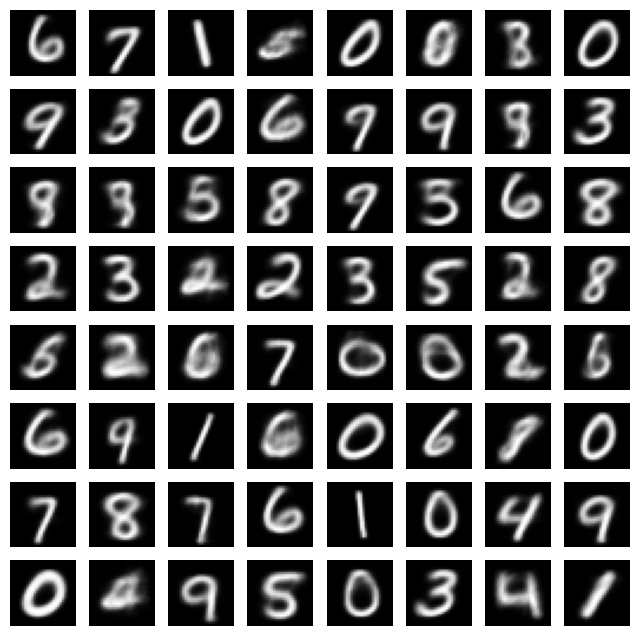

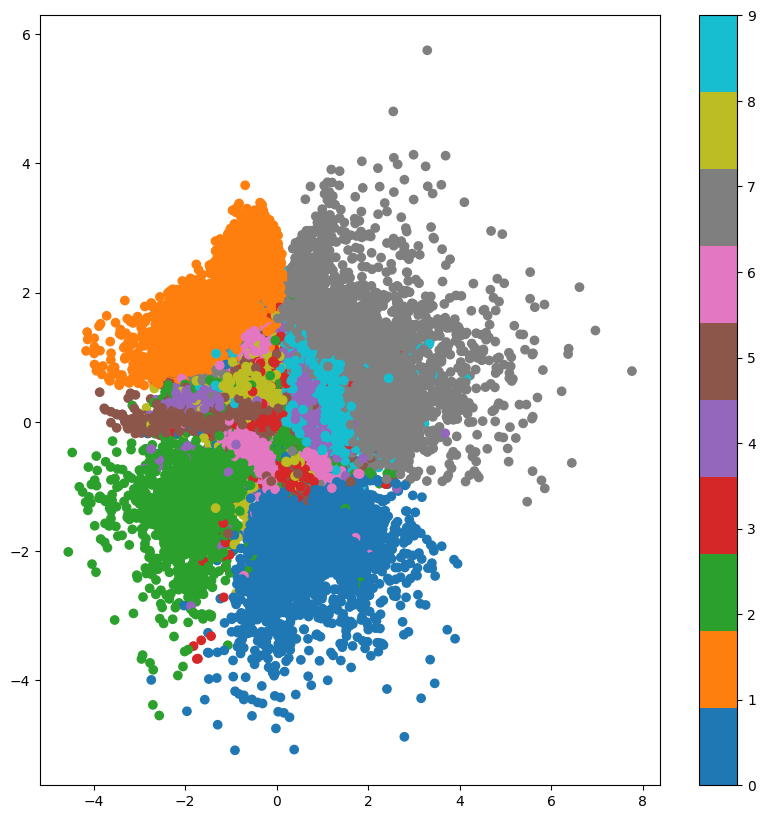

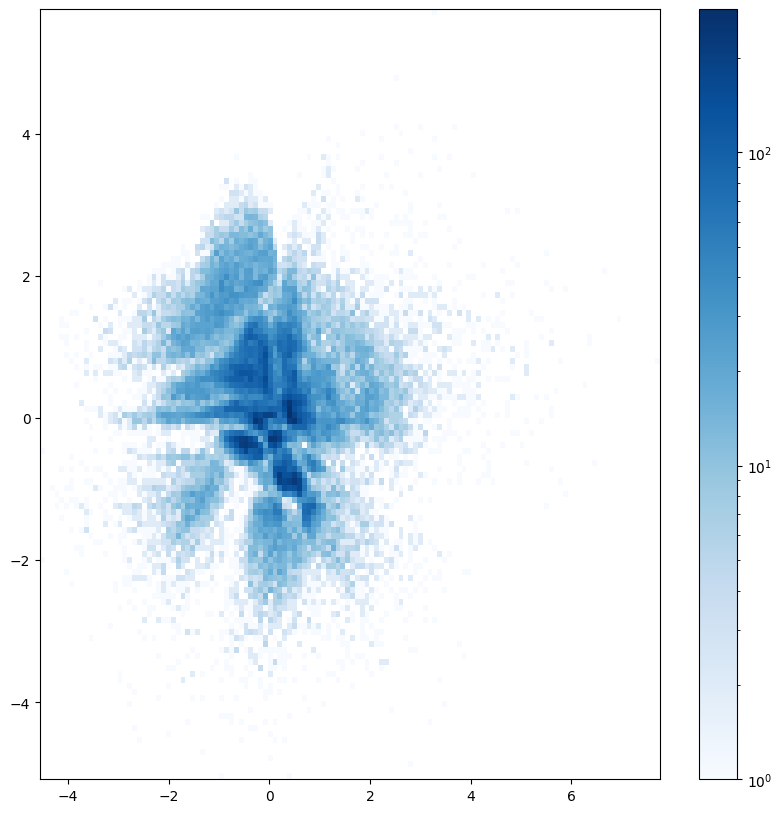

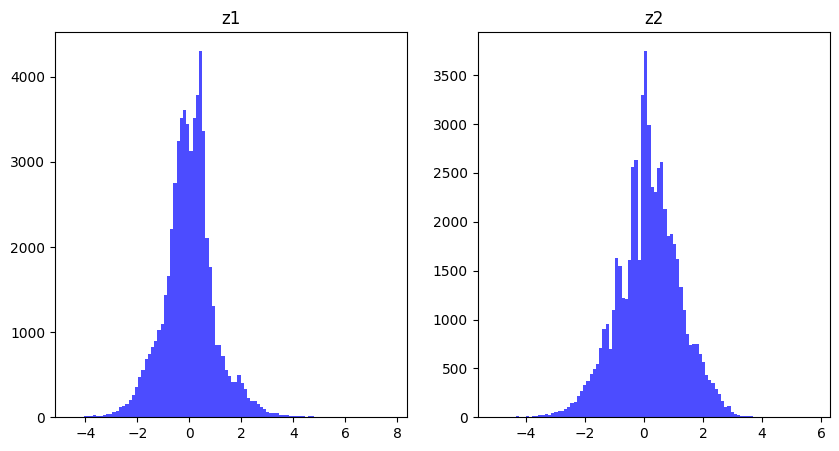

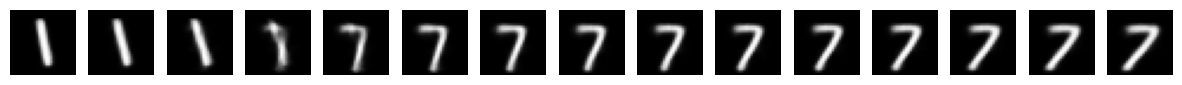

In [5]:
import matplotlib.pyplot as plt

z = torch.randn(64, latent_dim).to(device)
samples = model.decode(z)
# samples = torch.sigmoid(samples)

# print first sample
# print(samples[0])

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(
            samples[i * 8 + j].view(28, 28).cpu().detach().numpy(), cmap="gray"
        )
        ax[i, j].axis("off")

# plt.show()
plt.savefig("vae_mnist.webp")

# encode and plot the z values for the train set
model.eval()
z_all = []
y_all = []
with torch.no_grad():
    for data, target in tqdm(train_loader, desc="Encoding"):
        data = data.to(device)
        output = model(data, compute_loss=False)
        z_all.append(output.z_sample.cpu().numpy())
        y_all.append(target.numpy())
import numpy as np

z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap="tab10")
plt.colorbar()
# plt.show()
plt.savefig("vae_mnist_2d_scatter.webp")
# plot as 2d histogram, log scale
from matplotlib.colors import LogNorm

plt.figure(figsize=(10, 10))
plt.hist2d(z_all[:, 0], z_all[:, 1], bins=128, cmap="Blues", norm=LogNorm())
plt.colorbar()
# plt.show()
plt.savefig("vae_mnist_2d_hist.webp")
# plot 1d histograms
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(z_all[:, 0], bins=100, color="b", alpha=0.7)
ax[0].set_title("z1")
ax[1].hist(z_all[:, 1], bins=100, color="b", alpha=0.7)
ax[1].set_title("z2")
# plt.show()
plt.savefig("vae_mnist_1d_hist.webp")
n = 15
z1 = torch.linspace(-0, 1, n)
z2 = torch.zeros_like(z1) + 2
z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decode(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap="gray")
    ax[i].axis("off")

plt.savefig("vae_mnist_interp.webp")